This is the implementation of the algorith described in the report by João Afonso Batista.

I will shortly explain the notation used and how to utilize it for your own benefit.

every formula is a string where its variables are "V(0)","V(1)","V(2)"... and its connectives must have only one letter.
example:

"I(O(V(0),V(1)),V(2))" is the implication between x or y, and z. where x, y, z are variables.

I think that a quick obvervation of the examples laid down, starting with the simple hilbert calculus will be enough to make one able to use the algorithm.

Some notes:
The algorithm has both  syntatic and semantics integrated in it. The derivation is made with the inference rules, as explained in the report. In the case there is no derivation, the algorithm uses the semantic part to produce a valuation that works as a counter-model.

You don't have to input the semantic part of the algorithm, in which case the algorithm simply says that no derivation was found (if that is the case.)

In [1]:
import random
import time
from graphviz import *

In [2]:
def is_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

In [3]:
def unique(lis): #função que, dada uma lista, devolve a mesma lista sem elementos duplicados.
    r = []
    for i in lis:
        if i in r:
            pass
        else:
            r += [i]
    return r

In [4]:
unique([1,2,3,1,2,4,])

[1, 2, 3, 4]

In [5]:
def flatten(lis): #dada uma lista de listas, devolve uma lista com os elementos das listas pequenas
    r = []
    for i in lis:
        r = r + i
    return unique(r)

In [6]:
flatten([[1,2,3],[4,5,6],[7,8,9],[3,6,9]])

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [7]:
def subformaux(formula,conet): #função que, dada uma formula, devolve todas as subformulas. 
                            #conet é a lista com os simbolos usados para os conetores
                            #programa so funciona se os conetores forem apenas com 1 caracter de comprimento
                            #e o mesmo para as variaveis. representam-se como V(0),V(1),V(2)...
    
    simbolos = conet    
    form = formula
    
    r = []

    if form[0] in simbolos: 
        #significa que o primeiro simbolo é um conetor, ou seja, dentro dele conseguimos encontrar subformulas

        abertos = 0 #numero de parentesis abertos. a ideia é que as vírgulas importantes para este conetor aparecem quando
                    #há apenas 1 parentesis abertos a mais que o numero de parentesis fechados
            
        virgula = 1 #o método das virgulas só funciona para aridades maiores que 1.
        
        for i in range(len(form)):
            
            if form[i] == "(":
                abertos += 1
                
            elif form[i] == ")":
                abertos -= 1
                
            elif form[i] == "," and abertos == 1:
                
                r += subform(form[virgula+1:i],conet)
                
                virgula = i
                
        if virgula == 2: #este é o caso em que o conetor é de aridade 1 ou 0:
            aux = form[2:-1] #aux é o que "esta dentro" dos parenteses deste conetor
            
            if aux == "": #se aux é vazio, significa que estamos no caso de aridade 0:
                pass
                
            else: #se nao, estamos no caso de aridade 1
                r += subform(form[2:-1],conet)
                
        else:
            r += subform(form[virgula+1:-1],conet) #se estamos num caso de aridade maior que 1, falta contar com as subformulas
                                                   #que estao depois da "ultima" virgula
        return r + [form]
                    
    else:
        return r + [form]

In [8]:
def subform(formula, conet):
    return unique(subformaux(formula,conet))

In [9]:
subform("A(B(V(0),A(V(1),C(V(0))),C(V(2))),C(V(1)))",["A","B","C"])

['V(0)',
 'V(1)',
 'C(V(0))',
 'A(V(1),C(V(0)))',
 'V(2)',
 'C(V(2))',
 'B(V(0),A(V(1),C(V(0))),C(V(2)))',
 'C(V(1))',
 'A(B(V(0),A(V(1),C(V(0))),C(V(2))),C(V(1)))']

In [10]:
def substituir_variaveis(formula,lis):
    #esta funcao recebe uma formula e uma lista de subtituição da forma exemplo:
    #[["V(0)","E(V(0),V(1))"],["V(1)","V(0)"],["V(2)","I(V(1),V(0))"]]
    #e faz as substituiçoes da formula, substituindo todas as  variaveis "V(0)", por, neste caso, "E(V(0),V(1))",
    #todas as variaveis "V(1)" por, neste caso, "V(0)" and so on...
    
    r = ""
    j = 0
    for i in range(len(formula)-3): #vamos construir a nova formula
        
        if formula[i:i+4] in [i[0] for i in lis]: #significa que encontramos algo que temos que substituir
            
            r += formula[j:i]
            j = i+4
            
            indice = [k for k in range(len(lis)) if formula[i:i+4]==lis[k][0]][0] #entender que variavel encontramos
            
            r += lis[indice][1] #encaixar na variavel o que queremos substituir
    
    r += formula[j:]
    
    return r

In [11]:
substituir_variaveis("I(V(0),N(V(1)))",[["V(0)","I(V(0),V(1))"],["V(1)","V(0)"]])

'I(I(V(0),V(1)),N(V(0)))'

In [12]:
class inferencia:#classe para regras de inferencia
    
    def __init__(self,lis1,lis2,lis3):
        #cada regra é uma lista com 3 listas, a primeira com as premissas, a segunda com as conclusoes. 
        #a terceira é uma lista com as variaveis que aparecem na regra. esta informaçao vai ser importante
        #para fazer todas as possiveis intanciaçoes da regra
        
        self.premissas = lis1
        self.conclusoes = lis2
        self.variaveis = lis3
        self.numero_variaveis = len(lis3)
        
    def concretiza(self,lis): 
        #esta funçao devolve uma concretização desta regra segundo a lista de subtituição lis:
        #[["V(0)","E(V(0),V(1))"],["V(1)","V(0)"],["V(2)","I(V(1),V(0))"]]
        #e faz as substituiçoes da formula, substituindo todas as  variaveis "V(0)", por, neste caso, "E(V(0),V(1))",
        #todas as variaveis "V(1)" por, neste caso, "V(0)" and so on...
        
        r = [[], []]
        for i in self.premissas:
            r[0] += [substituir_variaveis(i,lis)]
        
        for i in self.conclusoes:
            r[1] += [substituir_variaveis(i,lis)]
        
        return r #notar que uma regra instanciada é apenas uma lista com duas listas, as premissas e as conclusoes.

In [13]:
class logica:
    def __init__(self,simbolos,aridades,separador):

        self.regras_inferencia = []
        
        self.separador = separador #separador é uma lista de formulas. era suposto chamar-se discriminator mas pronto.
        
        self.simbolos = simbolos #lista com os simbolos dos conetores.
        
        self.aridades = aridades
        
    def adiciona_regra_inferencia(self,lis1,lis2,lis3):
        #função para adicionar regras de inferencia a este calculo
        self.regras_inferencia += [inferencia(lis1,lis2,lis3)]
        
    def adiciona_atribuiçoes(self,atribuiçoes):
        self.atribuiçoes = atribuiçoes
        
    def adiciona_valores_de_verdade(self,valores, designados):
        self.valores_verdade = valores
        self.designados = designados

        
    def espaço_subformulas(self,premissas,conclusoes):
        #esta funcao calcula todas as subformulas das premissas ou das conclusoes
        
        espaço_subformulas = flatten([subform(j,self.simbolos) for j in (premissas + conclusoes)])
          
        return espaço_subformulas    
    
    
    def espaço_regras(self,premissa,conclusoes,espaço_subformulas,empty_set):
        #esta funçao calcula todas as concretizaçoes possiveis das regras de inferencia desta logica. utilizando apenas
        #as formulas pertencentes ao espaço de subformulas possiveis. visto ser um calculo analítico, este espaço
        #tem as subformulas das premissas e das conclusoes
        
        
        #cada regra é uma lista com duas entradas. a primeira é uma lista com as premissas e a segunda uma lista com as conclusoes
    
        espaço_regras = []
        for regra in self.regras_inferencia:
            
            numero_variaveis = regra.numero_variaveis
            
            #vamos fazer todas as combinaçoes possiveis de x formulas, onde x é o numero de variaveis na regra
            
            combinacoes_possiveis = [[["V(0)",i]] for i in espaço_subformulas]
            n = 1
            while n < numero_variaveis:
                
                combinacoes_possiveis = flatten([[j+[["V("+str(n)+")",i]] for i in espaço_subformulas] for j in combinacoes_possiveis])
                n += 1
                
            #agora vamos a cada regra, e concretizamos com todas as combinaçoes que obtemos.    
            
            for j in combinacoes_possiveis:
                espaço_regras += [regra.concretiza(j)]

        
        #se queremos uma prova empty-set, então só podemos utilizar regras que tenham nas premissas e nas conclusões, apenas
        #fórmulas que pertençam ao subconjunto de formulas de gamma e delta
        if empty_set:
            espaço_regras_empty_set = []
            for i in espaço_regras:
                if all([j in espaço_subformulas for j in i[0]]):
                    if all([j in espaço_subformulas for j in i[1]]):
                        espaço_regras_empty_set += [ i ]
                        
            return espaço_regras_empty_set
            
        #como isto é um calculo analitico, temos a seguinte certeza: existe uma prova onde so aparecem as formulas percentences
        #ao conjunto de subformulas de gamma e delta e thetas dessas formulas, podemos descartas regras concretizadas
        #que tenham nas premissas ou conclusoes formulas que nao pertençam aqueles dois conjuntos
        
        espaço_regras_aux = []
        
        formulas_que_aparecem = espaço_subformulas[:]
        
        for i in espaço_subformulas:
            
            for j in self.separador: #notar que as formulas no separador teem SEMPRE apenas uma variavel
                formulas_que_aparecem += [ substituir_variaveis(j,[["V(0)",i]]) ]
                
        
                
        formulas_que_aparecem = unique(formulas_que_aparecem)
        
        for i in espaço_regras:
            if all([j in formulas_que_aparecem for j in i[0]]):
                if all([j in formulas_que_aparecem for j in i[1]]):
                    espaço_regras_aux += [ i ]
            
        return espaço_regras_aux
    

    
    def variaveis_permanentes_para_heuristica(self,regras,conclusoes):
        #esta função é chamado logo no inicio da derivação, cria variáveis importantes que vão depois ser utilizadas
        
        
        #regras_finais sao as regras (já instanciadas) que temos a certeza que vao resultar em apenas folhas.
        #sao as regras cujas conclusao estao todas em Delta (as que nao teem conclusoes tambem satisfazem isto)
        regras_finais = [i for i in regras if all(i[1][j] in conclusoes for j in range(len(i[1])))]
        
        self.regras_finais = regras_finais
        
        espaço_premissas = flatten([i[0] for i in regras])
        
        self.espaço_premissas = espaço_premissas
            
        
            
            
        
        
        
         
        
    def heuristica_regras(self, formulas, regras, conclusoes):
        #esta função recebe um nó, e devolve a melhor regra a aplicar.
        #as formulas são as fórmulas no nó. 
        #regras são as regras que podem ser aplicadas neste nó, ou seja, das regras que foram usadas neste ramo, 
        #as que não concluem nenhuma regra neste nó e aquelas cujas premissas estão
        #contidas no conjunto de regras deste nó, 
        #conclusoes é o conjunto Delta
        
        
        #relembrar que as regras instanciadas sao representadas da forma de uma lista com 2 elementos.
        #o primeiro elemento é uma lista com as premissas
        #o segundo elemento é uma lista com as conclusoes
        
        
        #só podemos utilizar regras onde as suas premissas estao contidas nas formulas que estao no nó.
        #regras_utilizaveis = [i for i in regras if all([j in formulas for j in i[0]])]

        #vamos tambem tirar as regras que teem alguma conclusao que ja esta nas formulas deste no, usar essa regra é inutil.
        
        #regras_utilizaveis = [i for i in regras_utilizaveis if not any([i[1][j] in formulas for j in range(len(i[1]))])]
        regras_utilizaveis = regras
        #iremos primeiro verificar se existe alguma regra final que se possa utilizar. nesse caso, o ramo fecha.
        
        a = [i for i in self.regras_finais if i in regras_utilizaveis]
        
        if a != []:
            r = random.choice(a)
            return r
        
        
        #agora fazemos o seguinte: 
        #vemos qual a regras que mais nos aproxima de alguma regra final.
        
        #vamos ver qual a regra final cujas premissas estão o mais "quase incluidas" nas formulas do nosso nó
        
        b = [[i[0][:],i[1][:]] for i in self.regras_finais]
        
        for j in b:
            
            j[0] = [n for n in j[0] if n not in formulas]
            j += [len(j[0])]
            
        #b é agora uma lista com elementos da seguinte forma: 
        #primeira componente é uma lista com as premissas das regras finais que ainda nao estão nas formulas deste no
        #segunda componente sao as componentes dessa regra, nao precisamos realmente desta informaçao
        #terceira componente é o comprimento da primeira, ou seja, quantas premissas faltam ter nas formulas, para se poder usar
        #esta regra.
        
        #vamos agora, para cada formula no conjunto de subformulas, atribuir uma heuristica:
        
        espaço_formulas_nas_conclusoes = flatten([i[1] for i in regras_utilizaveis])
        
        formulas_com_heuristica = [[i,0] for i in espaço_formulas_nas_conclusoes]
        
        for j in espaço_formulas_nas_conclusoes:
            
            if j in conclusoes:
                #se a formula que vamos adicionar é uma conclusão, então este ramo fecha, é o melhor caso de todos.
                for z in formulas_com_heuristica:
                    if z[0] == j:
                        z[1] += 1000000
            
            else:
                for i in b:

                    #se a formula que queremos adicionar faz com que tenhamos todas as premissas de uma regra_final.  
                    #entao este ramo fecha, não neste passo, mas no próximo, este é o segundo melhor caso.
                    if i[2] == 1:
                        if j in i[0]:
                            for z in formulas_com_heuristica:
                                if z[0] == j:
                                    z[1] += 100000
                                    
                    #estes outros casos sao piores. representam que a formula que estamos a adicionar coloca-nos
                    #um pouco mais proximo de poder utilizar uma regra_final.
                    
                    #este é quando a formula é uma de duas que faltam para usar uma regra final. 
                    #vamos tentar ver o quao proximo estamos de chegar à outra fórmula.
                    elif i[2] == 2:
                        if j in i[0]:
                            
                            
                            
                            regras_utilizaveis_pos_j = [d for d in regras if all([f in formulas+[j] for f in d[0]])]
                            
                            regras_utilizaveis_pos_j = [d for d in regras_utilizaveis_pos_j if not any([d[1][f] in formulas+[j] for f in range(len(d[1]))])]
                            
                            formula_que_falta = [t for t in i[0] if t!=j][0]
                            
                            
                                
                            #vamos ver quantas regras concluem a formula que falta, quantas mais, maior a probabilidade 
                            #de conseguirmos obtela para depois usar a regra final.
                            for t in regras_utilizaveis_pos_j:
                                
                                
                                #agora vamos estimar o quão boa é essa regra.
                                if formula_que_falta in t[1]:
                                    #se ela so tiver essa conclusao, excelente
                                    if len(t[1]) == 1:
                                        for z in formulas_com_heuristica:
                                            if z[0] == j:

                                                z[1] += 5000
                                    
                                    
                                    
#estes casos nem sao considerados porque, ate agora, nao vi nehuma logica com regras que tenham mais que duas premissas.                                    
#                    elif i[2] == 3:

#                    elif i[2] == 4:
        
        melhor_regra = 0
        melhor_heuristica_regra = -1
        #vamos considerar a heuristica da regra o minimo das heuristicas das suas conclusoes.
        #uma regra, se tem n conclusoes, entao de 1 nó formam-se n nós. e a utilização desta regra só nos facilita
        #a vida se o pior destes nós é mais simples que o nó onde estavamos inicialmente.
        
        for r in regras_utilizaveis:
            heuristica_de_cada_regra = 10000000
            for conc in r[1]:
                heu = [i[1] for i in formulas_com_heuristica if i[0] == conc][0] 
                heuristica_de_cada_regra = min([heuristica_de_cada_regra,heu])
            
            
            if heuristica_de_cada_regra > melhor_heuristica_regra:
                
                melhor_heuristica_regra = heuristica_de_cada_regra
                
                melhor_regra = r

        
        return melhor_regra


    
    def desenha(self,arvore):
        #funcao que desenha a arvore, neste caso, desenhando um grafo
        g = Graph()
        
        #o nó inicial tem que ser cuidado de forma especial, visto que neste nó estão varias formulas,
        #e nos próximos só aquela que foi adicionada.
        if arvore[0][0] == []:
            raiz = "vazio"
        else:
            raiz = str(arvore[0][0])
        g.node(raiz)
        
        for i in arvore[1:]:
            nome = str(i[0][-1]) + "_" + str(i[2]) #string que o representa o nó
            g.node(nome) #cria o no
            
            pai = [j for j in arvore if j[2] == i[3]][0] #ve quem é o pai deste no
            
            
            if i[3] == 1: #tendo em conta a diferença se o pai é um no normal ou o no inicial: cria as arestas.
                g.edge(nome,raiz)
                
            else:
                nome_pai = str(pai[0][-1]) + "_" + str(pai[2])
                g.edge(nome,nome_pai)
        
        
        return g
    
    def prova(self,premissas,conclusoes,des = False, bol = False, empty_set = False, tempo = False, contra_modelo = False):
        #esta é a função principal, a que encontra derivações ou contra modelos para conjuntos de regras.
        #premissas e conclusões sao os conjuntos Gamma e Delta
        #des é um boleano, True para se for desejado desenhar a árvore da derivação e False caso contrário
        #bol tambem é um boleano. é True se for desejado devolver apenas True ou False consuante haja ou nao uma derivação
        #empty_set é um boleano, é True se for desejado que a derivação seja feita emptyset-analiticamente
        #tempo tambem é um boleano, é True se for desejado que se mostre o tempo de execução
        #contra_modelo é um boleano, é True se for desejado que se encontre uma atribuição que prova que gamma nao deriva delta,
                                                                                                            #se for esse o caso
        start = time.time()
        
        #construir o espaço de formulas que o calculo pode usar
        
        
        espaço_sub = self.espaço_subformulas(premissas,conclusoes)
        
        
        #se quisermos fazer um prova empty-set, em cada no da árvore, só podem a aparecer subformulas de gamma e delta,
        #impedindo assim que apareçam theta de formulas
        espaço_regras = self.espaço_regras(premissas,conclusoes,espaço_sub,empty_set)

  
        #função que calcula variáveis úteis para a heurística como as regras finais
        self.variaveis_permanentes_para_heuristica(espaço_regras,conclusoes)
        
        w = True
        
        #cada nó é representado por uma lista com 4 elementos. 
        #o primeiro é uma lista com as fórmulas nesse nó.
        #e o segundo é uma lista com as regras de inferencia já usadas para chegar até este nó
        #os ultimos 2 são o número do nó e o número do seu pai. para depois ajudar a desenhar a árvore. 
        
        numero_no = 1
        
        nos_abertos = [[premissas,[],numero_no,0]]
        
        arvore = []
        
        while w:
            if nos_abertos == []:
                #significa que todos os ramos já foram fechados e a prova está completa, concluimos que existe uma derivação
                r = True
                w = False
            else:
            
                no_a_atuar = nos_abertos[0]
                
                arvore += [no_a_atuar]

                nos_abertos = nos_abertos[1:]
                
                regras_nao_usadas = [i for i in espaço_regras if i not in no_a_atuar[1]]
                
                
                #nao iremos usar regras donde resulte um ramo igual ao que estamos.
                regras_nao_usadas = [i for i in regras_nao_usadas if not any([i[1][j] in no_a_atuar[0] for j in range(len(i[1]))])]

                #só vamos utilizar regras onde as premissas estejam todas contidas nas formulas deste nó
                regras_nao_usadas = [i for i in regras_nao_usadas if all([j in no_a_atuar[0] for j in i[0]])]
                
                if any(flatten([[i==j for i in conclusoes] for j in no_a_atuar[0]])): 
                    #este if é verdadeiro se alguma conclusão já se encontra no conjunto de formulas deste nó, logo
                    #este ramo fecha.
                    pass
                
                
                elif regras_nao_usadas == []:
                    #este if é verdadeiro se: no ramo que leva ao nó em que nós estamos, ja foram usadas todas as regras de 
                                            #inferencia possíveis, e nesse caso a prova é falsa.
                    r = False
                    w = False
                    r1 = no_a_atuar[0]
                    
                #elif [i for i in regras_nao_usadas if all([j in no_a_atuar[0] for j in i[0]])] == []:
                    #este if é verdadeiro se: não há nenhuma regra que se possa utilizar neste nó, que ainda nao tenha sido 
                    #usada. neste caso, a prova é falsa.
        
                
                #    r = False
                #    w = False
                #    r1 = no_a_atuar[0]
                
                else:
                    #escolhemos a regra, ja concretizada, que vamos usar. tendo em conta das fórmulas que já temos neste nó
                    #e as regras já usadas até aqui. só iremos escolher, de entre as regras todas, as que ainda não foram
                    #usadas previamente neste ramo.
                    #a função tem tambem como argumento as conclusoes para melhorar a heuristica de procura.
                    regra_a_usar = self.heuristica_regras(no_a_atuar[0],regras_nao_usadas,conclusoes)
                    

                    #depois de escolher a regra a utilizar, criamos x novos nós filhos deste nó, onde x é o número de 
                    #conclusões desta regra de inferência
                    
                    #colocaremos os novos nós no início da fila, para fazer um procura em profundidade primeiro.
                    
                    if len(regra_a_usar[1]) == 0: #criar os nos em que explode, só para aparecerem na arvore
                        
                        arvore += [ [no_a_atuar[0] + ["*"],no_a_atuar[1] + [regra_a_usar], numero_no+1,no_a_atuar[2]] ] 
                        numero_no += 1
                    
                    nos_abertos =  [  [unique(no_a_atuar[0] + [i]), no_a_atuar[1] + [regra_a_usar],numero_no+ regra_a_usar[1].index(i) + 1,no_a_atuar[2]] for i in regra_a_usar[1] ] + nos_abertos
        
                    numero_no += len(regra_a_usar[1])
            
        end = time.time()
        if tempo:
            print("tempo de execução (nao conta com o desenhar da arvor): " + str(end-start))
        if r:
            #print("A partir destas premissas é, de facto, sempre possível provar alguma destas conclusões.")
            if des:
                #print("A partir destas premissas é, de facto, sempre possível provar alguma destas conclusões.")
                return self.desenha(arvore)
            elif bol:
                return True
        else:
            #print("A partir destas premissas não é possível provar nenhuma destas conclusões e está aqui o conjunto de fórmulas que o mostram:")
            if bol:
                return False
            else:
                if contra_modelo:
                    return self.encontra_modelo(premissas, conclusoes, r1)
                else:
                    return r1
    
#########################################################################################################################################################    
#########################################################################################################################################################    
#########################################################################################################################################################    
#########################################################################################################################################################    
#this part is about the semantic algorithm
#the funtions that follow are necessary to, in case there is no derivation from gamma to delta, get the valuation
#that makes every formula in gamma designated and no formulas in delta designated

    def encontra_modelo(self,premissas, conclusoes, formulas):
        #isto é a funçao que, dado o "ramo" da prova que utiliza regras, encontra o contra modelo.
        #formulas são as formulas do ramo
        #premissas e conclusoes sao usadas para calcular todas as subformulas.
        
        #o resultado vai ser uma atribuiçao, não só as variaveis, mas tambem para todas as subformulas de gamma e delta
        r = {}
        
        subformulas = flatten([subform(j,self.simbolos) for j in (premissas + conclusoes)])
        
        possibilidades = [[i,self.valores_verdade] for i in subformulas]
        
        #para cada formula A, vamos ver se os thetas de A estao no ramo ou nao,
        #e assim diminuimos as possibilidades de valores de verdade que essa formula pode tomar.
        for i in subformulas:
            possiveis_valores_verdade = self.valores_verdade
            
            for j in self.separador:
                
                #a é theta de A
                a = substituir_variaveis(j,[["V(0)",i]])
                
                #se a está nas formulas, entao sabemos que theta(A) assume um valor de verdade designado
                #ou seja... A só pode assumir valores de verdade v tais que theta(v) é designado
                if a in formulas:
                    valores_verdade_aux = [z for z in self.valores_verdade if self.atribui_formula(j,{"V(0)":z})[0] in self.designados]
                    
                    
                #neste caso... theta(A) não é designado e podemos fazer um raciocinio semelhante e concluir que A pode
                #assumir todos os valores de verdade v tais que theta(v) nao é designado
                else:
                    valores_verdade_aux = [z for z in self.valores_verdade if self.atribui_formula(j,{"V(0)":z})[0] not in self.designados]
                
                possiveis_valores_verdade = [z for z in possiveis_valores_verdade if z in valores_verdade_aux]

            if len(possiveis_valores_verdade) != 1:
                print("isto nao era suposto acontecer... os thetas nao definiram unicamente o valor de verdade da formula")
            else:
                r[i] = possiveis_valores_verdade[0]
                
        return r
    
    def atribui_formula_aux(self,formula,atribuiçao):
        #uma atribuiçao é um dicionario em que as chaves sao "V(0)" ou "V(1)" ou ... e que devolve a atribuiçao dessa variavel

        #esta funcao, dada uma formula e uma atribuiçao, devolve uma formula que, no lugar das variaveis, tem valores de verdade.

        r = ""
        found_v = False
        variavel = ""
        for i in formula:
            if i == "V":
                found_v = True

            elif found_v:

                if i == ")":
                    found_v = False
                    r += atribuiçao["V("+variavel+")"]
                    variavel = ""

                elif i!= "(":
                    variavel += i
                    

            else:
                r += i

        return r

    def atribui_formula(self,formula,atribuiçao):
        #esta funcao, dada uma formula e uma atribuiçao, diz todos os valores de verdade que esta formula pode tomar.

        a = self.atribui_formula_aux(formula,atribuiçao)
            #"a" é a formula mas com as variaveis subtituidas pelos valores de verdade
            
        operador = a[0]
        

        if operador in self.valores_verdade:
            return [operador]

        else:
            aridade = self.aridades[self.simbolos.index(operador)]

            if aridade == 1:
                #vamos ver todas as possiveis

                valores_verdade = []
                for i in self.atribui_formula(a[2:-1],atribuiçao):
                    #i são os valores de verdade que o interior deste operador pode tomar, agora... para cada um deles
                    #vamos ver que valores de verdade resultam de aplicar o operador a esse valor de verdade 
                    
                    valores_verdade += self.atribuiçoes[str(operador)+"("+ i +")"]
                    
                    
                return unique(valores_verdade)
            
            
            else:

                b = a[2:-1]

                parentesis_abertos = 1

                virgulas = 0

                ultima_virgula = -1

                argumentos = []

                for i in range(len(b)):

                    if b[i] == "(":
                        parentesis_abertos += 1
                    elif b[i]  == ")":
                        parentesis_abertos -= 1
                    elif b[i] == "," and parentesis_abertos == 1:
                        
                        #argumentos tem os possiveis valores de verdade para cada argumento.

                        
                        argumentos += [self.atribui_formula(b[ultima_virgula+1:i],atribuiçao)]
                        
                        ultima_virgula = i
                        
                argumentos += [self.atribui_formula(b[ultima_virgula+1:],atribuiçao)]

                
                
                counter_max = [len(i) for i in argumentos]
                counter = [0 for i in argumentos]
                
                w = True
                valores_verdade = []
                
                #vamos, para cada combinaçao de valores de verdade nos argumentos deste operador, ver que valores de verdade
                #ele pode tomar.
                while w:
                    argumentos_aux = ""
                    for i in range(len(counter)):
                        argumentos_aux += argumentos[i][counter[i]] + "," 
                    
                    #construimos uma possivel concretização para este operador, agora vamos ver que valores de verdade
                    #ele pode tomar com esta concretização:
                    
                    valores_verdade += self.atribuiçoes[operador + "(" + argumentos_aux[:-1] + ")"]
                    
                    #agora vamos construir o proximo, ou seja.. basta "atualizar" o counter, uma ideia semelhante à usada
                    #na funcao "cria_atribuiçoes"
                    
                    w_aux = True
                    j = 1
                    while w_aux:
                        if j > len(counter):
                            w_aux = False
                            w = False
                        
                        else:
                            counter[-j] += 1

                            if counter[-j] >= counter_max[-j]:
                                counter[-j] = 0
                                j += 1


                            else:
                                w_aux = False
                            
                #depois deste ciclo, temos entao todos os valores de verdade que podem resultar daqui.
                
                return unique(valores_verdade)
                    
                
                
    def cria_atribuiçoes(self,numero_variaveis):
        r = []


        #este "counter" é o que contem a informaçao sobre como construir a atribuiçao, se o counter esta no estado 
        # [0,0,0,0] entao as 4 variaveis sao atribuidas o primeiro valor de verdade, se esta no estado
        #[1,0,0,0] entao a primeira variavel é atribuido o segundo valor de verdade e às outras o primeiro, and so on...
        counter = []
        for i in range(numero_variaveis):
            counter += [0]

        w = True
        while w:
            atri = {}

            for i in range(numero_variaveis):
                atri["V("+ str(i) +")"] = self.valores_verdade[counter[i]]

            r += [atri]

            #vamos somar 1 ao counter, isso tem o seguinte processo:
            #somamos 1 ao ultimo elemento, se ele for maior que o numero de valores de verdade, entao coloca-lo a zero
            #e somar 1 ao penultimo elemento, se ele for maior que o numero de valores de verdade, entao colcalo a zero e...
            w_aux = True
            j = 1
            while w_aux:
                if counter[-j] < len(self.valores_verdade) - 1:
                    counter[-j] += 1
                    w_aux = False

                elif j >= len(counter):
                    w_aux = False
                    w = False

                else:
                    counter[-j] = 0
                    j += 1

        return r

    def prova_semantica(self,premissas,conclusoes, bol = False,tempo = False):
        #dada um conjunto de premissas e um conjunto de conclusoes, verificar se, qualquer atribuiçao que faça com que
        #as premissas tenham todos um valor de verdade designado, algumas das conclusoes tambem tem.
        #se for esse o caso, a prova é verdadeira, se nao for esse o caso, a prova é falsa, e devolve-se a atribuiçao.
        
        #esta função só funciona para calculos deterministas, por so calcula todas as valoraçoes para as variaveis. 
        #Para calculos nao deterministas as atribuições também teriam 
        #que determinar o valor de verdade que dão a todas as subformulas de gamma e de delta.
        
        
        start = time.time()
        
        #vamos primeiro perceber qual é a maior variavel que temos
        variavel_maxima = 0
        for i in premissas+conclusoes:
            for j in i:
                if is_int(j):
                    variavel_maxima = max(variavel_maxima,int(j))
                    
        atribuiçoes = self.cria_atribuiçoes(variavel_maxima+1)
        r = True
        for i in atribuiçoes:
            if r:

                premissas_verdadeiras = True

                for j in premissas:
                #vamos verificar se, para esta atribuiçao "i", todas as premissas sao verdadeiras ou nao
                    if any([z in self.designados for z in self.atribui_formula(j,i)]):
                        #sifnifica que, para esta atribuiçao, esta premissa pode tomar um valor de verdade designado
                        pass

                    else:
                        premissas_verdadeiras = False

                if premissas_verdadeiras:
                    #significa que, para esta atribuiçao, todas as premissas podem assumir um valor de verdade designado

                    conclusao_falsa = False

                    for j in conclusoes:
                    #vamos verificar, para esta atribuiçao "i", que faz com que todas as premissas sejam verdadeiras,
                    #se faz com que todas as conclusoes sejam falsas, se sim, entao "i" é um contra modelo.

                        if any([z not in self.designados for z in self.atribui_formula(j,i)]):
                            #significa que, para esta atribuiçao, esta conclusao é falsa
                            conclusao_falsa = True
                        else:
                            #eu sei que isto é inutil mas é para assentar ideias e para ser mais simétrico.
                            pass

                    if conclusao_falsa:
                        #significa que, para esta atribuiçao, todas as premissas sao verdadeiras mas nenhuma conclusao é

                        r = False
                        r1 = i
                        
        end = time.time()
        if tempo:
            print(str(end-start))
        if r:
            #print("para qualquer atribuição que faz todas as premissas tomar um valor de verdade designado, uma conclusão também toda um valor de verdade designado")
            return r
        else:
            #print("esta atribuição faz com que todas as premissas tomem um valor de verdade designado mas nenhuma conclusão.")
            return r1  
                
   
    

Nas próximas linhas cria-se a lógica clássica de hilbert. exemplo 2.1 da página 7

In [14]:
CH = logica(["N","I","E","O"],[1,2,2,2],["V(0)"]) #os valores de verdade são só True e False logo "{p}" é um separador
#os simbolos sao representados por uma letra apenas
# N é o "não"
# I é a implicação
# E é a conjunção "e"
# O é a conjunção "ou"

In [15]:
CH.adiciona_regra_inferencia(["V(0)","N(V(0))"],[],["V(0)"])
CH.adiciona_regra_inferencia([],["V(0)","N(V(0))"],["V(0)"])
CH.adiciona_regra_inferencia(["E(V(0),V(1))"],["V(0)"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["E(V(0),V(1))"],["V(1)"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["V(0)","V(1)"],["E(V(0),V(1))"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["V(0)"],["O(V(0),V(1))"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["V(1)"],["O(V(0),V(1))"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["O(V(0),V(1))"],["V(0)","V(1)"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia([],["V(0)","I(V(0),V(1))"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["V(0)","I(V(0),V(1))"],["V(1)"],["V(0)","V(1)"])
CH.adiciona_regra_inferencia(["V(1)"],["I(V(0),V(1))"],["V(0)","V(1)"])

dicionario = {"N(t)":["f"],
 "N(f)":["t"],
 "I(t,t)":["t"],
 "I(t,f)":["f"],
 "I(f,t)":["t"],
 "I(f,f)":["t"],
 "O(t,t)":["t"],
 "O(f,t)":["t"],
 "O(t,f)":["t"],
 "O(f,f)":["f"],
 "E(t,t)":["t"],
 "E(f,t)":["f"],
 "E(t,f)":["f"],
 "E(f,f)":["f"]}

CH.adiciona_atribuiçoes(dicionario)
CH.adiciona_valores_de_verdade(["t","f"],["t"])

tempo de execução (nao conta com o desenhar da arvor): 0.0009980201721191406


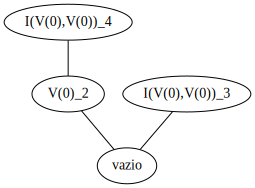

In [16]:
CH.prova([],["I(V(0),V(0))"],True, tempo = True)

In [17]:
CH.prova_semantica([],["I(V(0),V(0))"],True, tempo = True)

0.0


True

tempo de execução (nao conta com o desenhar da arvor): 0.003023862838745117


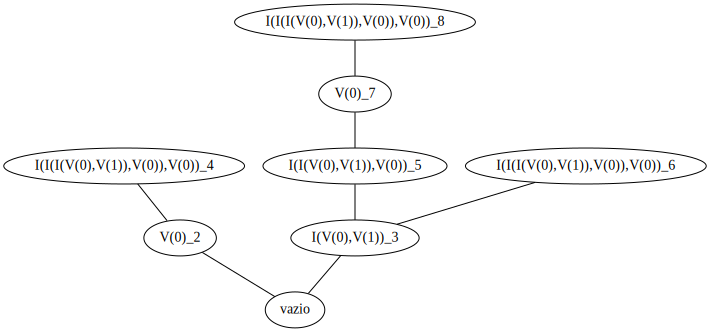

In [18]:
CH.prova([],["I(I(I(V(0),V(1)),V(0)),V(0))"],True, tempo = True)

In [19]:
CH.prova_semantica([],["I(I(I(V(0),V(1)),V(0)),V(0))"],True, tempo = True)

0.0


True

tempo de execução (nao conta com o desenhar da arvor): 0.0009996891021728516


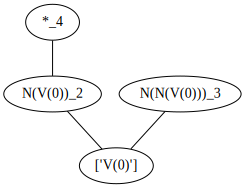

In [20]:
CH.prova(["V(0)"],["N(N(V(0)))"],True, tempo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.0010004043579101562


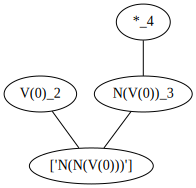

In [21]:
CH.prova(["N(N(V(0)))"],["V(0)"],True, tempo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.008975505828857422


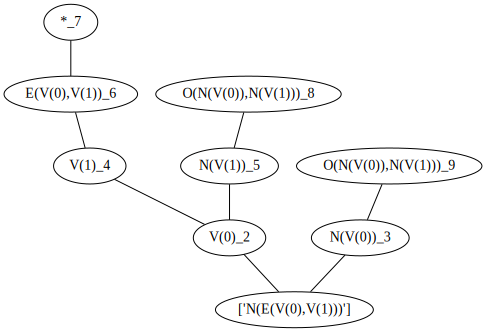

In [22]:
CH.prova(["N(E(V(0),V(1)))"],["O(N(V(0)),N(V(1)))"],True, tempo = True)

In [23]:
CH.prova(["V(0)"],["N(V(0))"],True, tempo = True, contra_modelo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.0


{'V(0)': 't', 'N(V(0))': 'f'}

In [24]:
CH.prova_semantica(["V(0)"],["N(V(0))"],True, tempo = True)

0.0


{'V(0)': 't'}

In [25]:
CH.prova(["I(V(0),I(V(1),V(2)))","E(V(1),V(2))"],["N(I(V(2),V(1)))","N(V(0))"],False, tempo = True,contra_modelo=True)

tempo de execução (nao conta com o desenhar da arvor): 0.008976221084594727


{'V(0)': 't',
 'V(1)': 't',
 'V(2)': 't',
 'I(V(1),V(2))': 't',
 'I(V(0),I(V(1),V(2)))': 't',
 'E(V(1),V(2))': 't',
 'I(V(2),V(1))': 't',
 'N(I(V(2),V(1)))': 'f',
 'N(V(0))': 'f'}

In [26]:
CH.prova_semantica(["I(V(0),I(V(1),V(2)))","E(V(1),V(2))"],["N(I(V(2),V(1)))","N(V(0))"],False, tempo = True)

0.0


{'V(0)': 't', 'V(1)': 't', 'V(2)': 't'}

Nas próximas linhas cria-se a lógica do exemplo 3.9 da página 12

In [27]:
T = logica(["B"],[2],["V(0)","B(V(0),V(0))"]) #os valores de verdade são {0,1,2} e "{p,B(p,p)}" é um separador
#os simbolos sao representados por uma letra apenas
# B é o único conetor, a "bola"

In [28]:
T.adiciona_regra_inferencia([],["B(B(V(0),V(1)),B(V(0),V(1)))"],["V(0)","V(1)"])
T.adiciona_regra_inferencia(["V(1)"],["B(V(0),V(1))"],["V(0)","V(1)"])
T.adiciona_regra_inferencia(["B(V(1),V(1))"],["V(1)","B(V(0),V(1))"],["V(0)","V(1)"])
T.adiciona_regra_inferencia(["B(V(0),V(0))"],["V(0)","B(V(0),V(1))"],["V(0)","V(1)"])
T.adiciona_regra_inferencia(["V(0)","B(V(0),V(1))"],["B(V(1),V(1))"],["V(0)","V(1)"])
T.adiciona_regra_inferencia(["B(V(0),V(1))"],["B(V(0),V(0))","B(V(1),V(1))"],["V(0)","V(1)"])

#dicionario = {"B(0,0)":["1"],
#              "B(0,1)":["2"],
#              "B(0,2)":["2"],
#              "B(1,0)":["2"],
#              "B(1,1)":["2"],
#              "B(1,2)":["2"],
#              "B(2,0)":["1"],
#              "B(2,1)":["2"],
#              "B(2,2)":["2"]}

#T.adiciona_atribuiçoes(dicionario)
#T.adiciona_valores_de_verdade(["0","1","2"],["2"])

In [30]:
T.prova([],["V(0)","B(V(0),V(0))"],True, tempo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.0010285377502441406


['B(B(V(0),V(0)),B(V(0),V(0)))']

tempo de execução (nao conta com o desenhar da arvor): 0.0029916763305664062


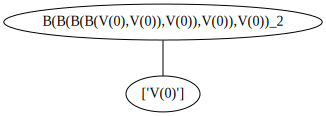

In [32]:
T.prova(["V(0)"],["B(B(B(B(V(0),V(0)),V(0)),V(0)),V(0))"],True, tempo = True)

In [33]:
T.prova(["B(B(B(B(V(0),V(0)),V(0)),V(0)),V(0))"],["V(0)","B(V(0),V(0))"],True, tempo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.0029914379119873047


['B(B(B(B(V(0),V(0)),V(0)),V(0)),V(0))',
 'B(B(V(0),V(0)),B(V(0),V(0)))',
 'B(B(B(V(0),V(0)),V(0)),B(B(V(0),V(0)),V(0)))',
 'B(B(B(B(V(0),V(0)),V(0)),V(0)),B(B(B(V(0),V(0)),V(0)),V(0)))',
 'B(B(B(B(B(V(0),V(0)),V(0)),V(0)),V(0)),B(B(B(B(V(0),V(0)),V(0)),V(0)),V(0)))',
 'B(B(V(0),V(0)),V(0))']

In [34]:
T.prova(["B(V(0),V(1))","B(V(1),V(2))"],["B(V(0),V(2))"],True, tempo = True)

tempo de execução (nao conta com o desenhar da arvor): 0.005020618438720703


['B(V(0),V(1))',
 'B(V(1),V(2))',
 'B(B(V(0),V(1)),B(V(0),V(1)))',
 'B(B(V(0),V(2)),B(V(0),V(2)))',
 'B(B(V(1),V(2)),B(V(1),V(2)))',
 'B(V(0),V(0))',
 'V(0)',
 'B(V(1),V(1))']

Nas próximas linhas cria-se a lógica do exemplo 3.10 da página 13

In [35]:
S = logica(["E","O","N"],[2,2,1],["V(0)","N(V(0))"]) #há 4 valores de verdade e "{p,N(p)}" é um separador
#os simbolos sao representados por uma letra apenas
# N é o "não"
# E é a conjunção "e"
# O é a conjunção "ou"

In [36]:
S.adiciona_regra_inferencia(["V(0)","V(1)"],["E(V(0),V(1))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["E(V(0),V(1))"],["V(0)"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["E(V(0),V(1))"],["V(1)"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["N(V(0))"],["N(E(V(0),V(1)))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["N(V(1))"],["N(E(V(0),V(1)))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["V(0)"],["O(V(0),V(1))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["V(1)"],["O(V(0),V(1))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["N(O(V(0),V(1)))"],["N(V(0))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["N(O(V(0),V(1)))"],["N(V(1))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["N(V(0))","N(V(1))"],["N(O(V(0),V(1)))"],["V(0)","V(1)"])
S.adiciona_regra_inferencia(["V(0)"],["N(N(V(0)))"],["V(0)"])
S.adiciona_regra_inferencia(["N(N(V(0)))"],["V(0)"],["V(0)"])

dicionario = {"N(t)":["f"],"N(f)":["t"],"N(T)":["T"],"N(F)":["F"]}

dicionario["E(f,f)"]=["f"]
dicionario["E(f,F)"]=["f"]
dicionario["E(f,T)"]=["f"]
dicionario["E(f,t)"]=["f"]

dicionario["E(F,f)"]=["f"]
dicionario["E(F,F)"]=["f","F"]
dicionario["E(F,T)"]=["f"]
dicionario["E(F,t)"]=["f","F"]

dicionario["E(T,f)"]=["f"]
dicionario["E(T,F)"]=["f"]
dicionario["E(T,T)"]=["T"]
dicionario["E(T,t)"]=["T"]

dicionario["E(t,f)"]=["f"]
dicionario["E(t,F)"]=["f","F"]
dicionario["E(t,T)"]=["T"]
dicionario["E(t,t)"]=["t","T"]



dicionario["O(f,f)"]=["f","T"]
dicionario["O(f,F)"]=["t","F"]
dicionario["O(f,T)"]=["T"]
dicionario["O(f,t)"]=["t"]

dicionario["O(F,f)"]=["t","F"]
dicionario["O(F,F)"]=["t","F"]
dicionario["O(F,T)"]=["t"]
dicionario["O(F,t)"]=["t"]

dicionario["O(T,f)"]=["T"]
dicionario["O(T,F)"]=["t"]
dicionario["O(T,T)"]=["T"]
dicionario["O(T,t)"]=["t"]

dicionario["O(t,f)"]=["t"]
dicionario["O(t,F)"]=["t"]
dicionario["O(t,T)"]=["t"]
dicionario["O(t,t)"]=["t"]

S.adiciona_atribuiçoes(dicionario)
S.adiciona_valores_de_verdade(["f","F","T","t"],["t","T"])

tempo de execução (nao conta com o desenhar da arvor): 0.005985260009765625


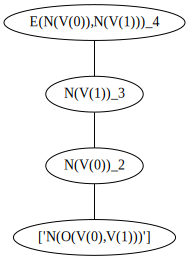

In [37]:
S.prova(["N(O(V(0),V(1)))"],["E(N(V(0)),N(V(1)))"],True, tempo = True,contra_modelo=True)

tempo de execução (nao conta com o desenhar da arvor): 0.00598454475402832


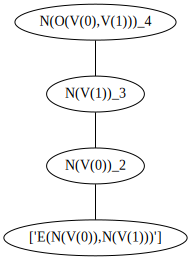

In [38]:
S.prova(["E(N(V(0)),N(V(1)))"],["N(O(V(0),V(1)))"],True, tempo = True)

In [39]:
S.prova(["N(E(V(0),V(1)))"],["O(N(V(0)),N(V(1)))"],True, tempo = True,contra_modelo=True)

tempo de execução (nao conta com o desenhar da arvor): 0.005983591079711914


{'V(0)': 'F',
 'V(1)': 'F',
 'E(V(0),V(1))': 'f',
 'N(E(V(0),V(1)))': 't',
 'N(V(0))': 'F',
 'N(V(1))': 'F',
 'O(N(V(0)),N(V(1)))': 'F'}

In [40]:
S.prova_semantica(["N(E(V(0),V(1)))"],["O(N(V(0)),N(V(1)))"],True, tempo = True)

0.000997304916381836


{'V(0)': 'F', 'V(1)': 'F'}

Notice how, in this previous example, the valuation gives to the formula "E(V(0),V(1))", when V(0) = F and V(1) = F, "E(V(0),V(1))" could be f or F.

tempo de execução (nao conta com o desenhar da arvor): 0.007978200912475586


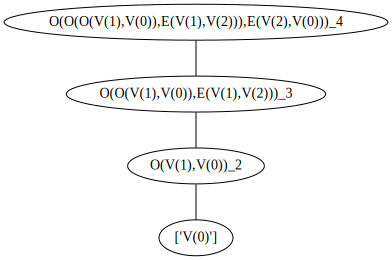

In [41]:
S.prova(["V(0)"],["O(O(O(V(1),V(0)),E(V(1),V(2))),E(V(2),V(0)))"],True, tempo = True)

In [42]:
S.prova(["O(E(V(0),V(1)),O(N(V(2)),V(1)))"],["O(N(V(0)),N(V(1)))","E(V(2),N(O(V(2),N(V(1)))))"],True, tempo = True,contra_modelo=True)

tempo de execução (nao conta com o desenhar da arvor): 0.023967266082763672


{'V(0)': 'F',
 'V(1)': 'F',
 'E(V(0),V(1))': 'F',
 'V(2)': 'F',
 'N(V(2))': 'F',
 'O(N(V(2)),V(1))': 'F',
 'O(E(V(0),V(1)),O(N(V(2)),V(1)))': 't',
 'N(V(0))': 'F',
 'N(V(1))': 'F',
 'O(N(V(0)),N(V(1)))': 'F',
 'O(V(2),N(V(1)))': 'F',
 'N(O(V(2),N(V(1))))': 'F',
 'E(V(2),N(O(V(2),N(V(1)))))': 'F'}

In [43]:
S.prova_semantica(["O(E(V(0),V(1)),O(N(V(2)),V(1)))"],["O(N(V(0)),N(V(1)))","E(V(2),N(O(V(2),N(V(1)))))"],True, tempo = True)

0.0009970664978027344


{'V(0)': 'f', 'V(1)': 'f', 'V(2)': 'f'}

In [35]:
conjuntos_a_analisar = []

In [36]:
conjuntos_explorados = []

In [37]:
def funcao_1(R1,R2,simbolos,separador,empty_set = False):
    #R1 e R2 sao conjuntos de regras. queremos verificar se, a partir de R1, conseguimos derivar todas as regras de R2
    
    #vamos entao criar a lógica criada pelo conjunto de regras R1
    
    logi = logica(simbolos,separador)
    
    for r in R1:
        logi.adiciona_regra_inferencia(r[0],r[1],r[2])
        
    #agora podemos começar a verificar se, a partir desta logica, conseguimos derivar cada regra em R2
    
    w = True
    
    for r in R2:#para cada regra em R2
        if w:
            if logi.prova(r[0],r[1],False,True,empty_set):
                #verificar se as suas premissas derivam alguma das suas conclusoes
                pass

            else:
                #caso contrario... entao R1 não deriva tudo o que R2 consegue derivar.
                w = False
    
    return w

In [38]:
def funcao_2(R,simbolos,separador,empty_set = False):
    start = time.time()
    global conjuntos_explorados
    global conjuntos_a_analisar
    
    #R é um conjunto de regras
    
    #queremos verificar se existe algum subconjunto de regras de R que derive todas as regras de R
    
    #a ideia é: vamos ao conjunto de regras que temos, fazer os subconjuntos que resultam de tirar uma regra
    
    #desses, vamos ver os que derivam R
    
    #desses, vamos repetir o processo, ou seja, fazer todos os subonjuntos que resultam de tirar uma regra e derivam o 
    #conjunto "pai"
    resposta = []
    
    conjunto_pai = R
    print(len(conjunto_pai))

    conjuntos_a_analisar = unique(conjuntos_a_analisar + [conjunto_pai])
        
    possiveis_respostas = [[i for i in conjunto_pai if i!=j] for j in conjunto_pai]
#possiveis_respostas é uma lista com todos os conjuntos filhos. conjuntos que resultam do conjunto_pai retirando-lhe 1 elemento
    
    random.shuffle(possiveis_respostas)
#fazemos um random shuffle, porque senão ele começa sempre por analisar retirar as regras iniciais... se quisermos isso
#não fazemos suffle, mas imaginando que as regras estão distribuidas aleatoriamente... então faz sentido não dar
#prioridade a nenhuma.
    
    
    for r in possiveis_respostas:
        if r not in conjuntos_explorados:
        #se ele estiver em conjuntos_explorados é porque já foi analisado, e podemos ignora-lo, evitando repetições.
        
            if funcao_1(r, conjunto_pai,simbolos,separador,empty_set):
                #se este conjunto deriva o conjunto pai... então vamos chamar recursivamente esta função.
                resposta += funcao_2(r,simbolos,separador,empty_set)

    if resposta == []:
#no caso em que nenhum filho deriva o pai, então devolvemos o conjunto pai, visto que ele é um possivel conjunto para dereivar R
        resposta = [ conjunto_pai ]
    
    for i in resposta:
        conjuntos_explorados += [ i ]
    
    conjuntos_explorados = unique(conjuntos_explorados)
    end = time.time()
    print("tempo de execução: " + str(end-start))
    return unique(resposta)
            

In [43]:
def prova_SAT(nome, limite):
    #esta função faz os problemas SAT do site https://www.cs.ubc.ca/~hoos/SATLIB/benchm.html
    #este ciclo serve apenas para transformar a notação do ficheiro na notação usada para o programa.
    a = open(nome,"r")
    w = True
    gama = []
    b = ""
    while len(b) != 1:

        b = a.readline()
        if len(gama)<=limite:
            if b[0] == "c" or b[0] == "p" or b[0] == "%" or b[0] == "0" or len(b)==1:
                pass
            else:
                variaveis = []
                var = ""
                for i in b:

                    if i == " ": #or i == "0":
                        if var != "":
                            variaveis += [var]
                        var = ""
                    elif i == "0" and var == "":
                        pass
                    else:
                        var += i

                for i in range(len(variaveis)):
                    if variaveis[i][0] == "-":
                        variaveis[i] = "N(V("+variaveis[i][1:]+"))"

                    else:
                        variaveis[i] = "V("+variaveis[i]+")"

                formula = "O(O("+variaveis[0]+","+variaveis[1]+"),"+variaveis[2]+")"

                gama += [ formula ]
    
    print(gama)
            
    return CH.prova(gama,[],tempo = True, contra_modelo = True)

In [46]:
prova_SAT("uf20-01.cnf",30)

['O(O(V(4),N(V(18))),V(19))', 'O(O(V(3),V(18)),N(V(5)))', 'O(O(N(V(5)),N(V(8))),N(V(15)))', 'O(O(N(V(20)),V(7)),N(V(16)))', 'O(O(V(10),N(V(13))),N(V(7)))', 'O(O(N(V(12)),N(V(9))),V(17))', 'O(O(V(17),V(19)),V(5))', 'O(O(N(V(16)),V(9)),V(15))', 'O(O(V(11),N(V(5))),N(V(14)))', 'O(O(V(18),N(V(10))),V(13))', 'O(O(N(V(3)),V(11)),V(12))', 'O(O(N(V(6)),N(V(17))),N(V(8)))', 'O(O(N(V(18)),V(14)),V(1))', 'O(O(N(V(19)),N(V(15))),V(10))', 'O(O(V(12),V(18)),N(V(19)))', 'O(O(N(V(8)),V(4)),V(7))', 'O(O(N(V(8)),N(V(9))),V(4))', 'O(O(V(7),V(17)),N(V(15)))', 'O(O(V(12),N(V(7))),N(V(14)))', 'O(O(N(V(10)),N(V(11))),V(8))', 'O(O(V(2),N(V(15))),N(V(11)))', 'O(O(V(9),V(6)),V(1))', 'O(O(N(V(11)),V(20)),N(V(17)))', 'O(O(V(9),N(V(15))),V(13))', 'O(O(V(12),N(V(7))),N(V(17)))', 'O(O(N(V(18)),N(V(2))),V(20))', 'O(O(V(20),V(12)),V(4))', 'O(O(V(19),V(11)),V(14))', 'O(O(N(V(16)),V(18)),N(V(4)))', 'O(O(N(V(1)),N(V(17))),N(V(19)))', 'O(O(N(V(13)),V(15)),V(10))']
tempo de execução (nao conta com o desenhar da arvor): 170

{'V(4)': 't',
 'V(18)': 't',
 'N(V(18))': 'f',
 'O(V(4),N(V(18)))': 't',
 'V(19)': 't',
 'O(O(V(4),N(V(18))),V(19))': 't',
 'V(3)': 't',
 'O(V(3),V(18))': 't',
 'V(5)': 't',
 'N(V(5))': 'f',
 'O(O(V(3),V(18)),N(V(5)))': 't',
 'V(8)': 't',
 'N(V(8))': 'f',
 'O(N(V(5)),N(V(8)))': 'f',
 'V(15)': 'f',
 'N(V(15))': 't',
 'O(O(N(V(5)),N(V(8))),N(V(15)))': 't',
 'V(20)': 't',
 'N(V(20))': 'f',
 'V(7)': 't',
 'O(N(V(20)),V(7))': 't',
 'V(16)': 't',
 'N(V(16))': 'f',
 'O(O(N(V(20)),V(7)),N(V(16)))': 't',
 'V(10)': 't',
 'V(13)': 't',
 'N(V(13))': 'f',
 'O(V(10),N(V(13)))': 't',
 'N(V(7))': 'f',
 'O(O(V(10),N(V(13))),N(V(7)))': 't',
 'V(12)': 't',
 'N(V(12))': 'f',
 'V(9)': 't',
 'N(V(9))': 'f',
 'O(N(V(12)),N(V(9)))': 'f',
 'V(17)': 't',
 'O(O(N(V(12)),N(V(9))),V(17))': 't',
 'O(V(17),V(19))': 't',
 'O(O(V(17),V(19)),V(5))': 't',
 'O(N(V(16)),V(9))': 't',
 'O(O(N(V(16)),V(9)),V(15))': 't',
 'V(11)': 't',
 'O(V(11),N(V(5)))': 't',
 'V(14)': 't',
 'N(V(14))': 'f',
 'O(O(V(11),N(V(5))),N(V(14)))':